# Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import divexplorer 
import pandas as pd
pd.set_option('max_colwidth', None)
import os
import numpy as np

from utils_analysis import filter_itemset_df_by_attributes, slice_by_itemset, \
    plot_true_pred, plotComparisonShapleyValues, plotMultipleSV, plotMultipleSV_4, plotShapleyValue

In [3]:
## Define the minimum support threshold for data subgroups
min_sup = 0.03

# Util Functions

In [4]:
## Function for sorting data cohorts
def sortItemset(x, abbreviations={}):
    x = list(x)
    x.sort()
    x = ", ".join(x)
    for k, v in abbreviations.items():
        x = x.replace(k, v)
    return x

In [5]:
def attributes_in_itemset(itemset, attributes, alls = True):
    """ Check if attributes are in the itemset (all or at least one)
    
    Args:
        itemset (frozenset): the itemset
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        
    """
    # Avoid returning the empty itemset (i.e., info of entire dataset)
    if itemset == frozenset() and attributes:
        return False
    
    for item in itemset:
        # Get the attribute
        attr_i = item.split("=")[0]
        
        #If True, check if ALL attributes of the itemset are the input attributes.
        if alls:
            # Check if the attribute is present. If not, the itemset is not admitted
            if attr_i not in attributes:
                return False
        else:
            # Check if least one attribute. If yes, return True
            if attr_i in attributes:
                return True
    if alls:
        # All attributes of the itemset are indeed admitted
        return True
    else:
        # Otherwise, it means that we find None
        return False
    
def filter_itemset_df_by_attributes(df: pd.DataFrame, attributes: list, alls = True, itemset_col_name: str = "itemsets") -> pd.DataFrame:
    """Get the set of itemsets that have the attributes in the input list (all or at least one)
    
    Args:
        df (pd.DataFrame): the input itemsets (with their info). 
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        itemset_col_name (str) : the name of the itemset column, "itemsets" as default
        
    Returns:
        pd.DataFrame: the set of itemsets (with their info)
    """

    return df.loc[df[itemset_col_name].apply(lambda x: attributes_in_itemset(x, attributes, alls = alls))]

In [6]:
## Function for substituting gender of a given itemset
substitute_gender = lambda x : "gender=M" if "gender=F" in x else ("gender=F" if "gender=M" in x else x)

In [7]:
## Define abbreviations for plot and visualization
from divexplorer.FP_Divergence import abbreviateDict
abbreviations = {'total_silence': 'tot_silence', \
                  'speaker_id' : 'spkID', \
                  'trimmed': 'trim', \
                  'total_':'tot_', \
                  'speed_rate_word_trimmed': 'speakRate_trim', \
                  'trim_duration': 'trim_dur', \
                  'speed_rate_word':'speakRate', \
                  'speed_rate_char':'speakCharRate', \
                  'duration': 'dur'}

abbreviations_shorter = abbreviations.copy()

In [8]:
n = 3  # Number of subgroups to visualize
K = 25  # Global Shapley values to visualize

# Define targets

In [9]:
## Target for DivExplorer: 'WER'
target_col = 'WER' 
target_metric = 'd_outcome'
target_div = f'd_{target_col}'
t_value_col = 't_value_outcome'
printable_columns = ['support', 'itemsets','WER', 'd_WER', 't_value']

In [10]:
## Columns for visualization
remapped_cols = { "outcome": target_col, "d_outcome": target_div, t_value_col: 't_value'}
show_cols = ['support', 'itemsets', target_col, target_div, 'support_count', 'length', 't_value']

In [11]:
## Columns of the df file that we are going to analyze 
demo_cols = ['gender']

signal_cols = ['total_silence', 'total_duration', 'trimmed_duration', 
       'n_pauses', 'n_words', 'speed_rate_word', 'speed_rate_word_trimmed'] 

input_cols = demo_cols + signal_cols 

# Retrieve Data and Compute Divergence

In [12]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.FP_Divergence import FP_Divergence

In [13]:
configs = ["wav2vec2-base", "wav2vec2-large", "hubert-base", "hubert-large"]

FP_fm_dict = {}
fp_divergence_dict = {}
df_dict = {}

for config in configs:

    print(config)

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "LibriSpeech", f"LibriSpeech_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0)
    df[target_col] = df[target_col]

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )
    
    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
                
    ## Create dict of Divergence df
    df_dict[config] = df_discretized

    fp_diver = FP_DivergenceExplorer(df_discretized, target_name=target_col)
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])
        
    FP_fm.rename(columns = remapped_cols, inplace = True)
    FP_fm = FP_fm[show_cols].copy()
    FP_fm['WER'] = round(FP_fm['WER'], 5)
    FP_fm['d_WER'] = round(FP_fm['d_WER'], 5)
    FP_fm['t_value'] = round(FP_fm['t_value'], 2)
    FP_fm_dict[config] = FP_fm
    fp_divergence_dict[config] = FP_Divergence(FP_fm, target_div)

wav2vec2-base


wav2vec2-large
hubert-base
hubert-large


In [14]:
## Compute WER for each config
from jiwer import wer

for config in configs:

    print(config)
    
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "LibriSpeech", f"LibriSpeech_for_DivExplorer_{config}.csv") 
    df = pd.read_csv(input_file_divexplorer, index_col=0)
    df[target_col] = df[target_col]
    ground_truth = list(df['text'])
    hypothesis =list(df['transcription'])
    
    print((wer(ground_truth, hypothesis)*100))
    print("-------------")

wav2vec2-base
6.063603164942179
-------------
wav2vec2-large
3.815429093122337
-------------
hubert-base
6.558125380401704
-------------
hubert-large
3.495891661594644
-------------


In [15]:
WAV2VEC2_BASE_WER = 6.06
WAV2VEC2_LARGE_WER = 3.82
HUBERT_BASE_WER = 6.56
HUBERT_LARGE_WER = 3.50

In [16]:
## Test Samples
config = 'wav2vec2-base'
print("Test Samples: ", len(df_dict[config]))
print("Subgroup Explored: ", len(FP_fm_dict[config]))

Test Samples:  2620
Subgroup Explored:  2414


In [17]:
import time
from tqdm import tqdm

## Compute time for the DivExplorer algorithm
overall_time = []

for i in tqdm(range(10)):

    config = "wav2vec2-base"

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "LibriSpeech", f"LibriSpeech_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col=0)
    df[target_col] = df[target_col]

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )
    
    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)

    start_time = time.time()
    fp_diver = FP_DivergenceExplorer(df_discretized, target_name=target_col)
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])
    overall_time.append(time.time() - start_time)

print("Average time: ", np.mean(overall_time))
print("Worst time: ", np.max(overall_time))

 10%|█         | 1/10 [00:00<00:01,  5.17it/s]

100%|██████████| 10/10 [00:02<00:00,  4.65it/s]

Average time:  0.1471609115600586
Worst time:  0.22228360176086426


# Divergence Wav2Vec2-Base

In [18]:
## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]

,itemsets,support,WER,d_WER,t_value
2410,"gender=F, n_pauses=low, speakRate_trim=high, trim_dur=low",0.03,17.298,11.238,4.16
2407,"gender=F, n_pauses=low, speakRate_trim=high, tot_dur=low",0.03,17.027,10.967,4.04
1909,"gender=F, speakRate=high, speakRate_trim=high, trim_dur=low",0.04,16.470,10.410,4.43


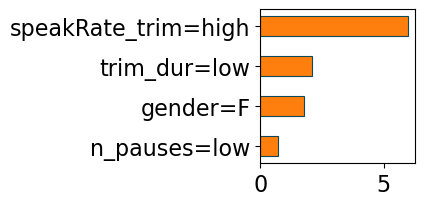

In [19]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = ((pr["WER"] - WAV2VEC2_BASE_WER)).round(3)
pr_l = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_i.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

In [20]:
negative_itemset = frozenset({'gender=F', 'n_pauses=low', 'speed_rate_word_trimmed=high','total_duration=low'})

config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("wav2vec2-base")
print("WER: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_BASE_WER,3))
print("Support: ", pr_ni[pr_ni['itemsets'] == negative_itemset].support.values[0])
print("T-Value: ", pr_ni[pr_ni['itemsets'] == negative_itemset].t_value.values[0])
print("------------------\n")

config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("wav2vec2-large")
print("WER: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_LARGE_WER,3))
print("------------------\n")

config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("hubert-base")
print("WER: ", wer)
print("Δ_WER: ", round(wer - HUBERT_BASE_WER,3))
print("------------------\n")

config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("hubert-large")
print("WER: ", wer)
print("Δ_WER: ", round(wer - HUBERT_LARGE_WER,3))

wav2vec2-base
WER:  17.027
Δ_WER:  10.967
Support:  0.03015267175572519
T-Value:  4.04
------------------

wav2vec2-large
WER:  11.314
Δ_WER:  7.494
------------------

hubert-base
WER:  16.066
Δ_WER:  9.506
------------------

hubert-large
WER:  10.782
Δ_WER:  7.282


In [21]:
positive_itemset = frozenset({'gender=M', 'n_pauses=low', 'speed_rate_word_trimmed=high','total_duration=low'})

config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == positive_itemset].WER.values[0]*100
print("wav2vec2-base")
print("WER: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_BASE_WER,3))
print("Support: ", pr_ni[pr_ni['itemsets'] == positive_itemset].support.values[0])
print("T-Value: ", pr_ni[pr_ni['itemsets'] == positive_itemset].t_value.values[0])
print("------------------\n")

config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == positive_itemset].WER.values[0]*100
print("wav2vec2-large")
print("WER: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_LARGE_WER,3))
print("------------------\n")

wav2vec2-base
WER:  10.139
Δ_WER:  4.079
Support:  0.04045801526717557
T-Value:  1.5
------------------

wav2vec2-large
WER:  10.434000000000001
Δ_WER:  6.614
------------------



WER:  10.759
Δ_WER:  4.699


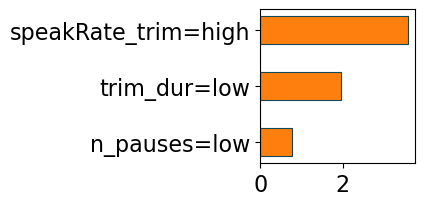

In [22]:
## Subgroup: {'n_pauses=low', 'speakRate_trim=high', 'trim_dur=low'}
negative_itemset = frozenset({'n_pauses=low', 'speed_rate_word_trimmed=high','trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("WER: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_BASE_WER,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

In [23]:
## retrieve divegence for the subgroup {gender=F}
itemset_gender = frozenset({'gender=F', 'speed_rate_word_trimmed=high','trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == itemset_gender].WER.values[0]*100
print("WER gender alone: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_BASE_WER,3))
print("--------------")

itemset_spkrate = frozenset({'speed_rate_word_trimmed=high'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == itemset_spkrate].WER.values[0]*100
print("WER speaking rate alone: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_BASE_WER,3))
print("--------------")

itemset_duration = frozenset({'trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == itemset_duration].WER.values[0]*100
print("WER duration alone: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_BASE_WER,3))
print("--------------")

itemset_pauses = frozenset({'n_pauses=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == itemset_pauses].WER.values[0]*100
print("WER pause alone: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_BASE_WER,3))
print("--------------")

WER gender alone:  10.968
Δ_WER:  4.908
--------------
WER speaking rate alone:  6.038
Δ_WER:  -0.022
--------------
WER duration alone:  5.745
Δ_WER:  -0.315
--------------
WER pause alone:  4.849
Δ_WER:  -1.211
--------------


gender=F 	 WER: 11.332 	 d_WER: 5.272 	 Support: 0.03
-----------
gender=M 	 WER: 10.336 	 d_WER: 4.276 	 Support: 0.041
-----------


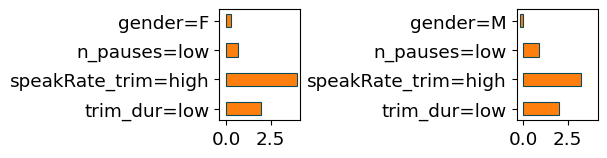

In [24]:
import warnings
warnings.filterwarnings("ignore")

# Compute Shapley Values for the given itemset, when changing the gender
genders = ['gender=F', 'gender=M']
itemset_shaps = []
for gender in genders:
    itemset_gender = negative_itemset.union([gender])
    wer = round(pr_ni[pr_ni['itemsets'] == itemset_gender]['WER'].values[0]*100,3)
    d_wer = round(pr_ni[pr_ni['itemsets'] == itemset_gender]['WER'].values[0]*100 - WAV2VEC2_BASE_WER,3)
    support = round(pr_ni[pr_ni['itemsets'] == itemset_gender]['support'].values[0],3)
    print(gender, "\t WER:", wer, "\t d_WER:", d_wer, "\t Support:", support)
    print("-----------")
    itemset_shaps.append(fp_divergence_i.computeShapleyValue(itemset_gender))

height = 0.45
sizeFig = (6.5,2.5)
labelsize = 13.3
pad = 4
nameFig = "plot_results/LibriSpeech/local-shapley-wb-gender-positive"
plotComparisonShapleyValues(abbreviateDict(itemset_shaps[0], abbreviations), \
                            abbreviateDict(itemset_shaps[1], abbreviations), \
                            sizeFig=sizeFig, sharedAxis=True, sort="alp", \
                            height=height, labelsize=labelsize, pad=pad, \
                            saveFig=False, nameFig=nameFig, subcaption=False)

In [25]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = (pr["WER"] - WAV2VEC2_BASE_WER).round(3)
pr_l = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,WER,d_WER,t_value
2073,"gender=M, n_pauses=low, n_words=medium, speakRate=low",0.04,1.770,-4.290,6.79
1424,"gender=M, n_words=medium, speakRate=low",0.05,1.849,-4.211,7.24
1885,"gender=M, n_words=medium, speakRate=low, speakRate_trim=low",0.04,1.866,-4.194,6.80


WER:  2.124
Δ_WER:  -3.936


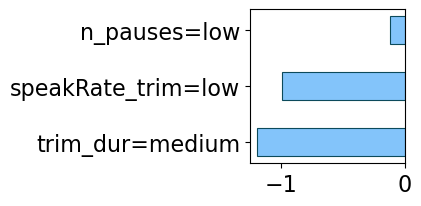

In [26]:
## Subgroup: {'n_pauses=low', 'speakRate_trim=low', 'trim_dur=medium'}
positive_itemset = frozenset({'n_pauses=low', 'speed_rate_word_trimmed=low', 'trimmed_duration=medium'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1]
pr_pi = FPdiv.copy()
wer = pr_pi[pr_pi['itemsets'] == positive_itemset].WER.values[0]*100
print("WER: ", round(wer,3))
print("Δ_WER: ", round(wer - WAV2VEC2_BASE_WER,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

gender=F 	 WER: 1.982 	 d_WER: -4.078 	 Support: 0.037
-----------
gender=M 	 WER: 2.288 	 d_WER: -3.772 	 Support: 0.032
-----------


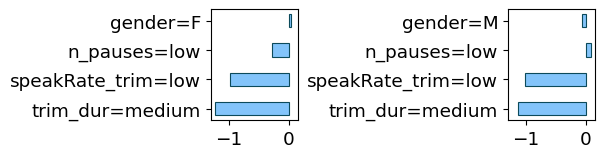

In [27]:
# Compute Shapley Values for the given itemset, when changing the gender
genders = ['gender=F', 'gender=M']
itemset_shaps = []
for gender in genders:
    itemset_gender = positive_itemset.union([gender])
    wer = round(pr_pi[pr_pi['itemsets'] == itemset_gender]['WER'].values[0]*100,3)
    d_wer = round(pr_pi[pr_pi['itemsets'] == itemset_gender]['WER'].values[0]*100 - WAV2VEC2_BASE_WER,3)
    support = round(pr_ni[pr_ni['itemsets'] == itemset_gender]['support'].values[0],3)
    print(gender, "\t WER:", wer, "\t d_WER:", d_wer, "\t Support:", support)
    print("-----------")
    itemset_shaps.append(fp_divergence_i.computeShapleyValue(itemset_gender))

height = 0.45
sizeFig = (6.5,2.5)
labelsize = 13.3
pad = 4
nameFig = "plot_results/LibriSpeech/local-shapley-wb-gender-negative"
plotComparisonShapleyValues(abbreviateDict(itemset_shaps[0], abbreviations), \
                            abbreviateDict(itemset_shaps[1], abbreviations), \
                            sizeFig=sizeFig, sharedAxis=True, sort="alp", \
                            height=height, labelsize=labelsize, \
                            pad=pad, negative=True,subcaption=False, \
                            saveFig=False, nameFig=nameFig)

---------- Individual Divergence ----------


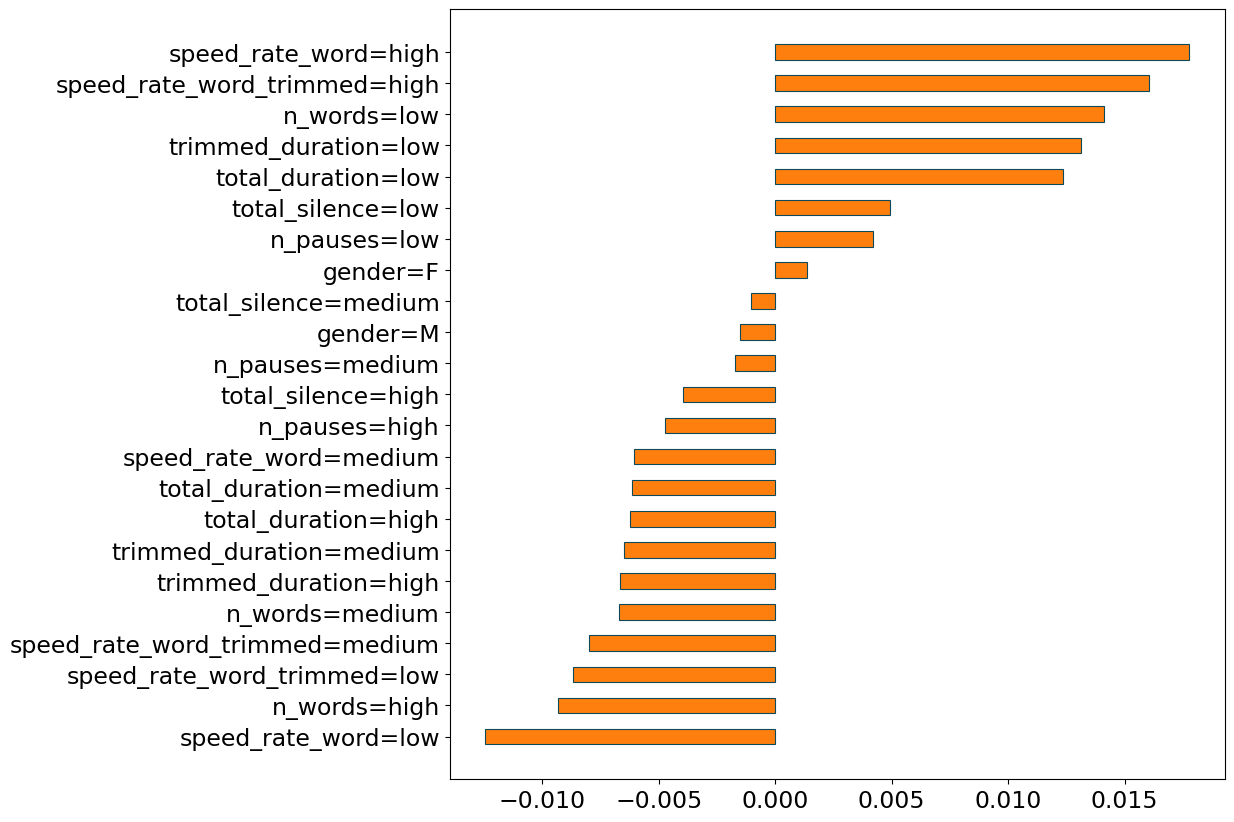

---------- Global Divergence ----------


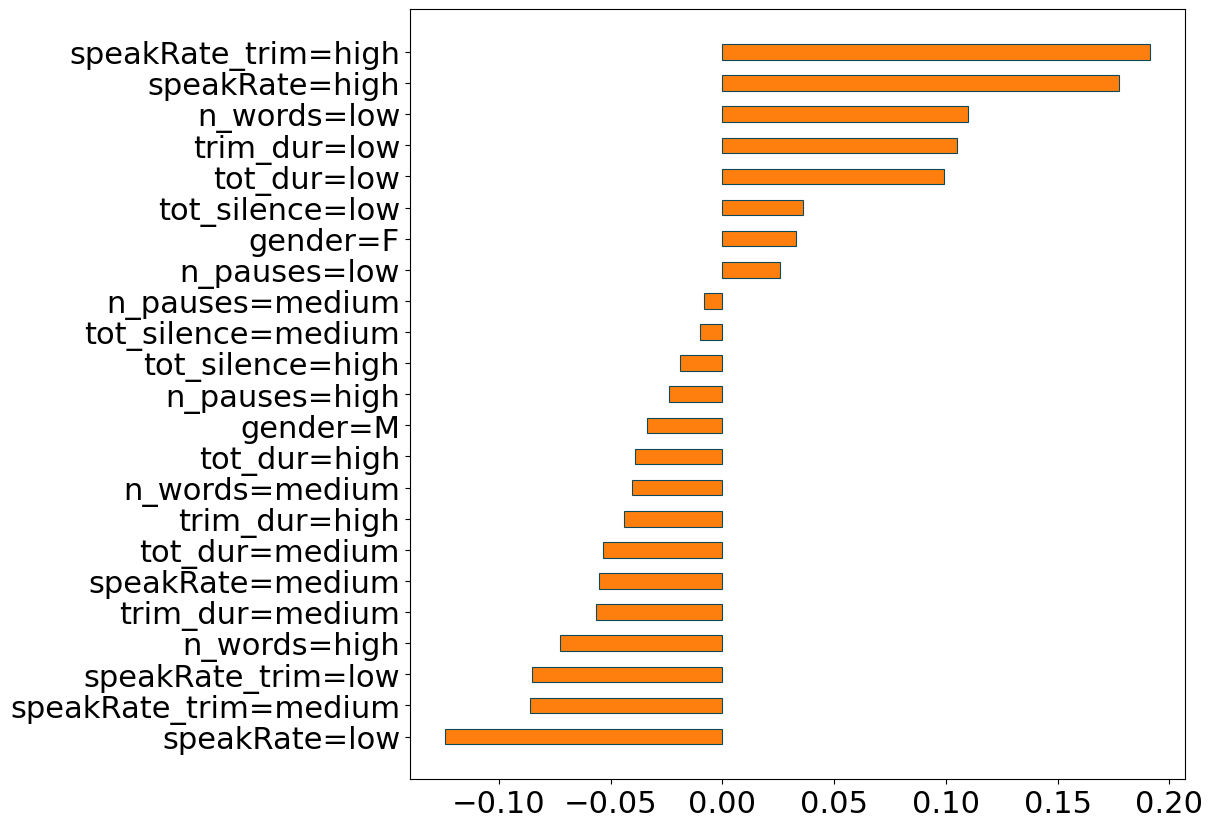

In [28]:
# Individual and Global Divergence
print("---------- Individual Divergence ----------")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

print("---------- Global Divergence ----------")
global_item_divergence_wav2b = fp_divergence_i.computeGlobalShapleyValue()

topK_global_wavb = {k:v*100 for k,v in global_item_divergence_wav2b.items() 
                if k in sorted(global_item_divergence_wav2b, 
                key=lambda x: abs(global_item_divergence_wav2b[x]))[::-1][:K]} 

nameFig = "plot_results/LibriSpeech/global-shapley-wb.pdf"
plotShapleyValue(shapley_values=(abbreviateDict(topK_global_wavb, abbreviations)), 
                sizeFig=(10,10), labelsize=22, titlesize=22,
                saveFig=True, nameFig=nameFig)

# Divergence Wav2Vec2-Large

In [29]:
## Compute the divergence for wav2vec 2.0 large (300m)
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]

,itemsets,support,WER,d_WER,t_value
1484,"speakRate=high, speakRate_trim=high, tot_dur=low, tot_silence=low",0.05,12.559,8.739,3.53
1514,"speakRate=high, speakRate_trim=high, tot_dur=low, tot_silence=low, trim_dur=low",0.05,12.529,8.709,3.47
1482,"speakRate=high, speakRate_trim=high, tot_silence=low, trim_dur=low",0.05,12.404,8.584,3.47


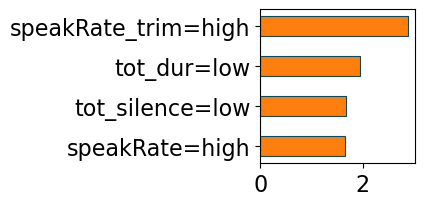

In [30]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = ((pr["WER"] - WAV2VEC2_LARGE_WER)).round(3)
pr_l = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_i.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

In [31]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = (pr["WER"] - WAV2VEC2_LARGE_WER).round(3)
pr_l = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,WER,d_WER,t_value
2073,"gender=M, n_pauses=low, n_words=medium, speakRate=low",0.04,1.770,-2.050,6.79
1424,"gender=M, n_words=medium, speakRate=low",0.05,1.849,-1.971,7.24
1885,"gender=M, n_words=medium, speakRate=low, speakRate_trim=low",0.04,1.866,-1.954,6.80


WER:  11.332
Δ_WER:  7.512


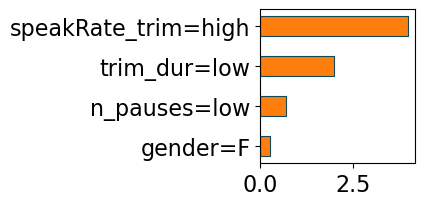

WER:  10.335999999999999
Δ_WER:  6.516


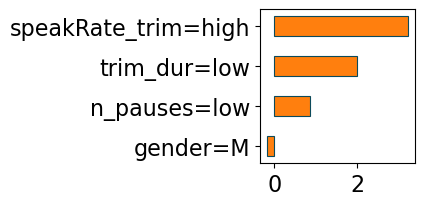

In [32]:
## Subgroup: {'gender=F', 'speakRate_trim=high', 'n_pauses=low', 'trim_dur=low'}
negative_itemset = frozenset({'gender=F', 'speed_rate_word_trimmed=high', 'n_pauses=low', 'trimmed_duration=low'})
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("WER: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_LARGE_WER,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)


## Subgroup: {'gender=M', 'speakRate_trim=high', 'n_pauses=low', 'trim_dur=low'}
negative_itemset = frozenset({'gender=M', 'speed_rate_word_trimmed=high', 'n_pauses=low', 'trimmed_duration=low'})
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("WER: ", wer)
print("Δ_WER: ", round(wer - WAV2VEC2_LARGE_WER,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

---------- Individual Divergence ----------


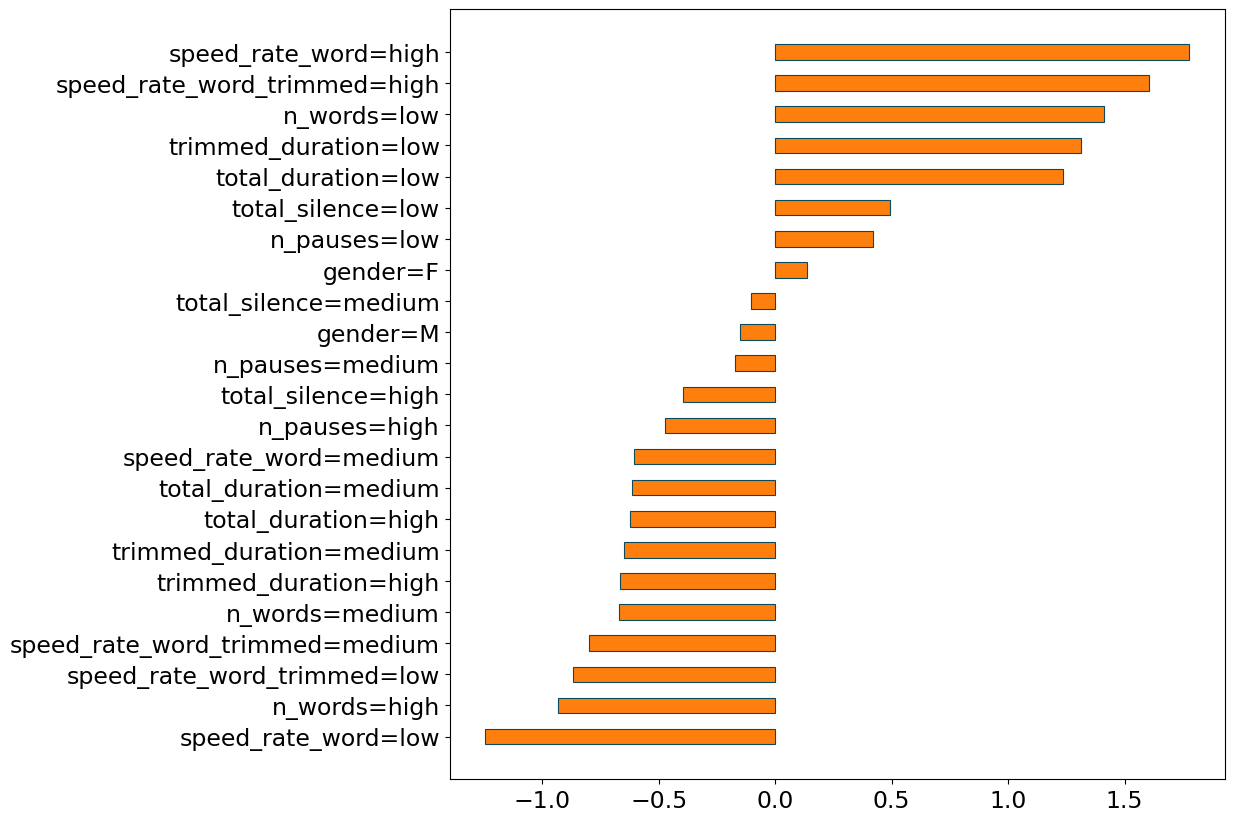

---------- Global Divergence ----------


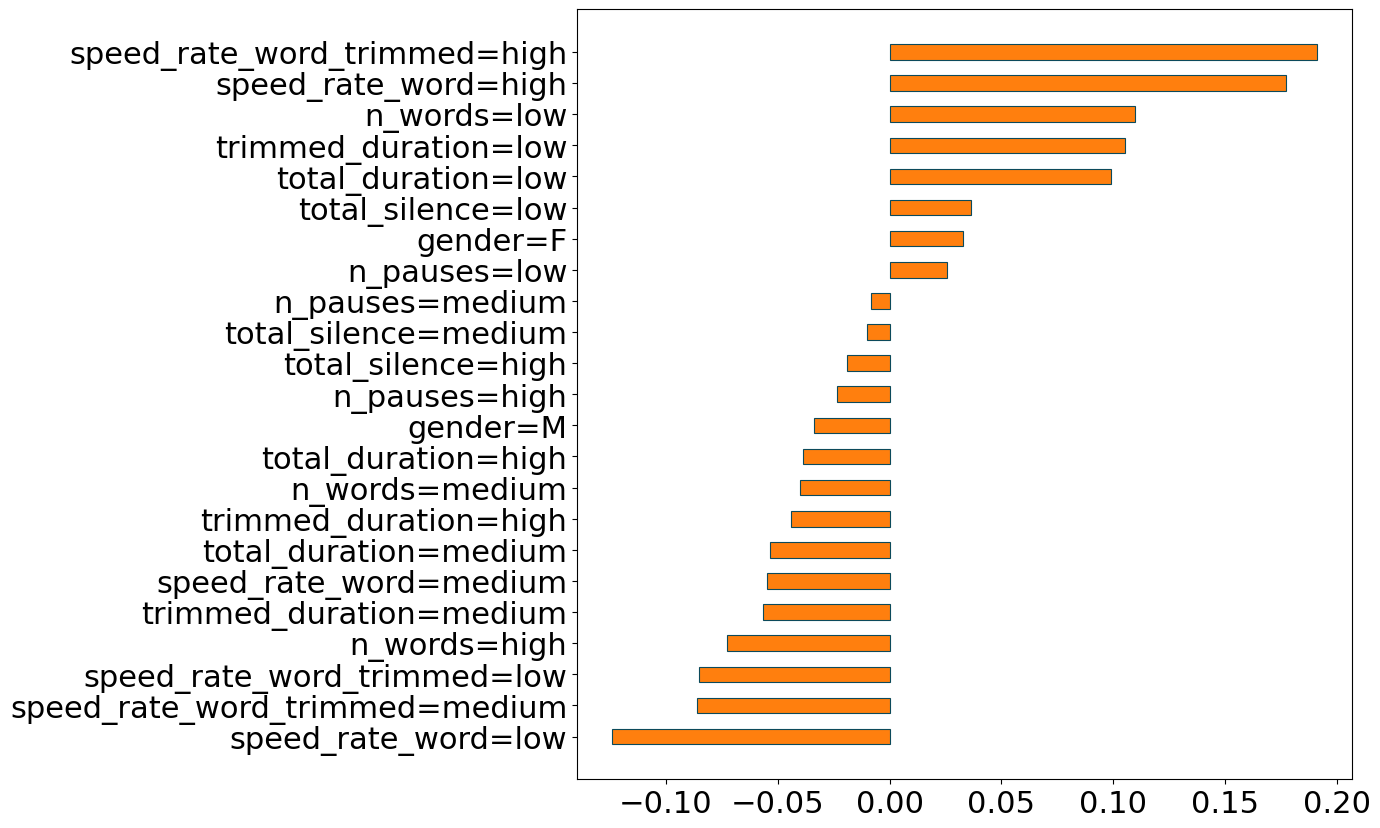

In [33]:
# Individual and Global Divergence
print("---------- Individual Divergence ----------")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

print("---------- Global Divergence ----------")
global_item_divergence_wav2l = fp_divergence_i.computeGlobalShapleyValue()

topK_global_wavl = {k:v*100 for k,v in global_item_divergence_wav2l.items() 
                    if k in sorted(global_item_divergence_wav2l, 
                    key=lambda x: abs(global_item_divergence_wav2l[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_wavl, 
                sizeFig=(10,10), labelsize=22, titlesize=22)

# Divergence HuBERT-Base

In [34]:
## Compute the divergence for HuBERT base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]

,itemsets,support,WER,d_WER,t_value
2410,"gender=F, n_pauses=low, speakRate_trim=high, trim_dur=low",0.03,16.464,9.904,3.54
1909,"gender=F, speakRate=high, speakRate_trim=high, trim_dur=low",0.04,16.262,9.702,4.03
1886,"gender=F, speakRate_trim=high, trim_dur=low",0.04,16.211,9.651,4.04


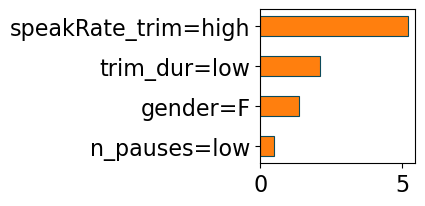

In [35]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = ((pr["WER"] - HUBERT_BASE_WER)).round(3)
pr_l = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_i.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

In [36]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = (pr["WER"] - HUBERT_BASE_WER).round(3)
pr_l = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,WER,d_WER,t_value
1885,"gender=M, n_words=medium, speakRate=low, speakRate_trim=low",0.04,3.735,-2.825,7.18
2009,"gender=F, n_pauses=low, speakRate_trim=low, trim_dur=medium",0.04,3.764,-2.796,6.44
2192,"gender=M, n_words=medium, speakRate=low, speakRate_trim=low, trim_dur=medium",0.03,3.773,-2.787,6.43


WER:  13.26
Δ_WER:  6.7


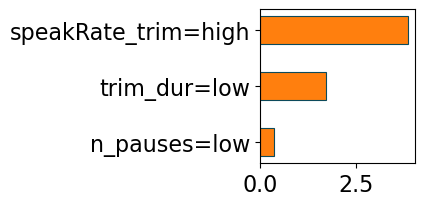

In [37]:
## Subgroup: {'speakRate_trim=high', 'n_pauses=low', 'trim_dur=low'}
negative_itemset = frozenset({'n_pauses=low', 'speed_rate_word_trimmed=high','trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("WER: ", wer)
print("Δ_WER: ", round(wer - HUBERT_BASE_WER,3))
itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

WER:  4.221
Δ_WER:  -2.339


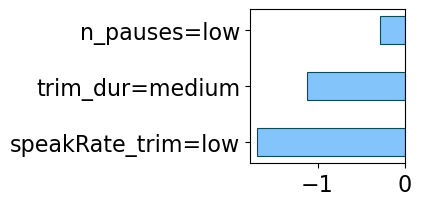

In [38]:
## Subgroup: {'speakRate_trim=low', 'n_pauses=low', 'trim_dur=medium'}
positive_itemset = frozenset({'n_pauses=low', 'speed_rate_word_trimmed=low', 'trimmed_duration=medium'})
wer = pr_ni[pr_ni['itemsets'] == positive_itemset].WER.values[0]*100
print("WER: ", wer)
print("Δ_WER: ", round(wer - HUBERT_BASE_WER,3))

itemset_shap = fp_divergence_i.computeShapleyValue(positive_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

WER:  16.262
Δ_WER:  9.702


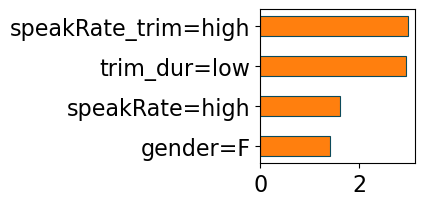

WER:  11.617
Δ_WER:  5.057


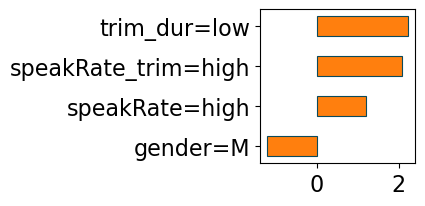

In [39]:
## Subgroup: {'gender=F', 'speakRate_trim=high', 'speakRate=high', 'trim_dur=low'}
negative_itemset = frozenset({'gender=F', 'speed_rate_word_trimmed=high', 'speed_rate_word=high', 'trimmed_duration=low'})
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("WER: ", wer)
print("Δ_WER: ", round(wer - HUBERT_BASE_WER,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Subgroup: {'gender=M', 'speakRate_trim=high', 'speakRate=high', 'trim_dur=low'}
negative_itemset = frozenset({'gender=M', 'speed_rate_word_trimmed=high', 'speed_rate_word=high', 'trimmed_duration=low'})
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("WER: ", round(wer,3))
print("Δ_WER: ", round(wer - HUBERT_BASE_WER,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

---------- Individual Divergence ----------


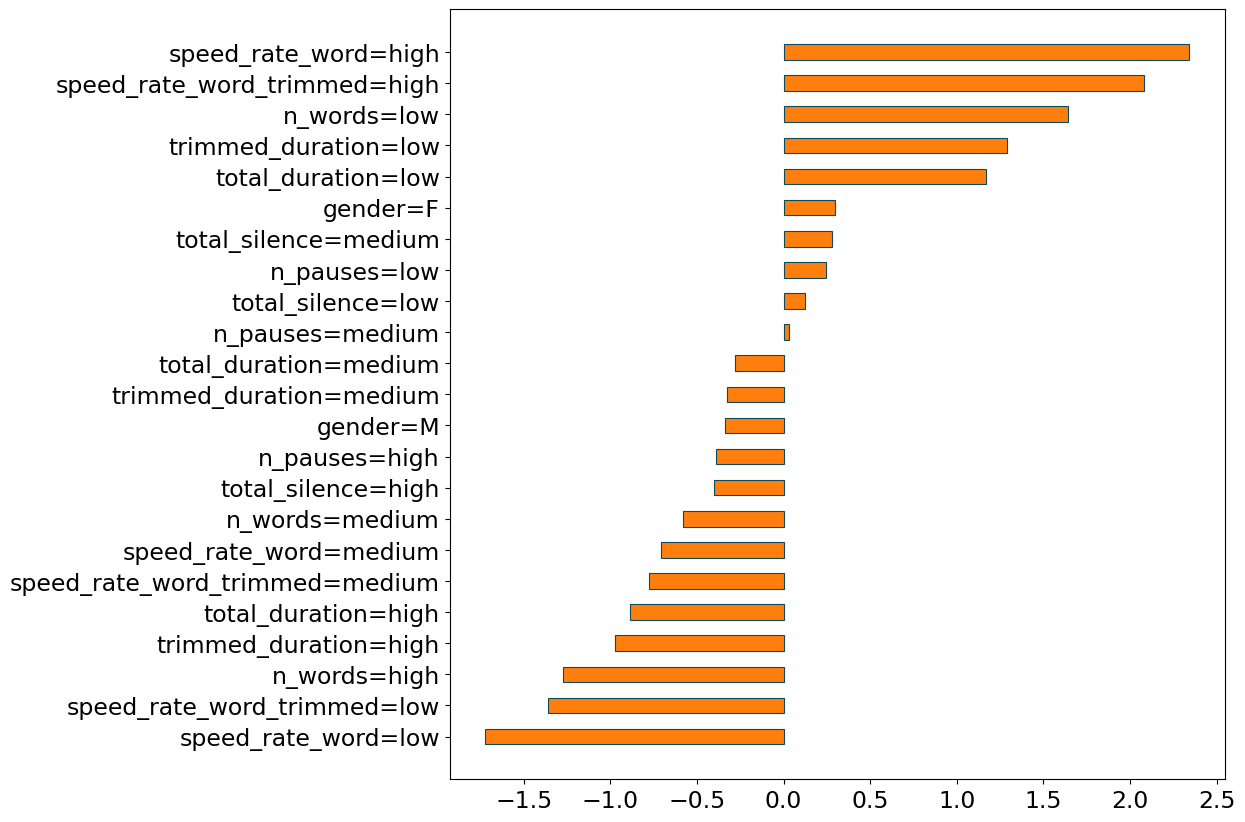

---------- Global Divergence ----------


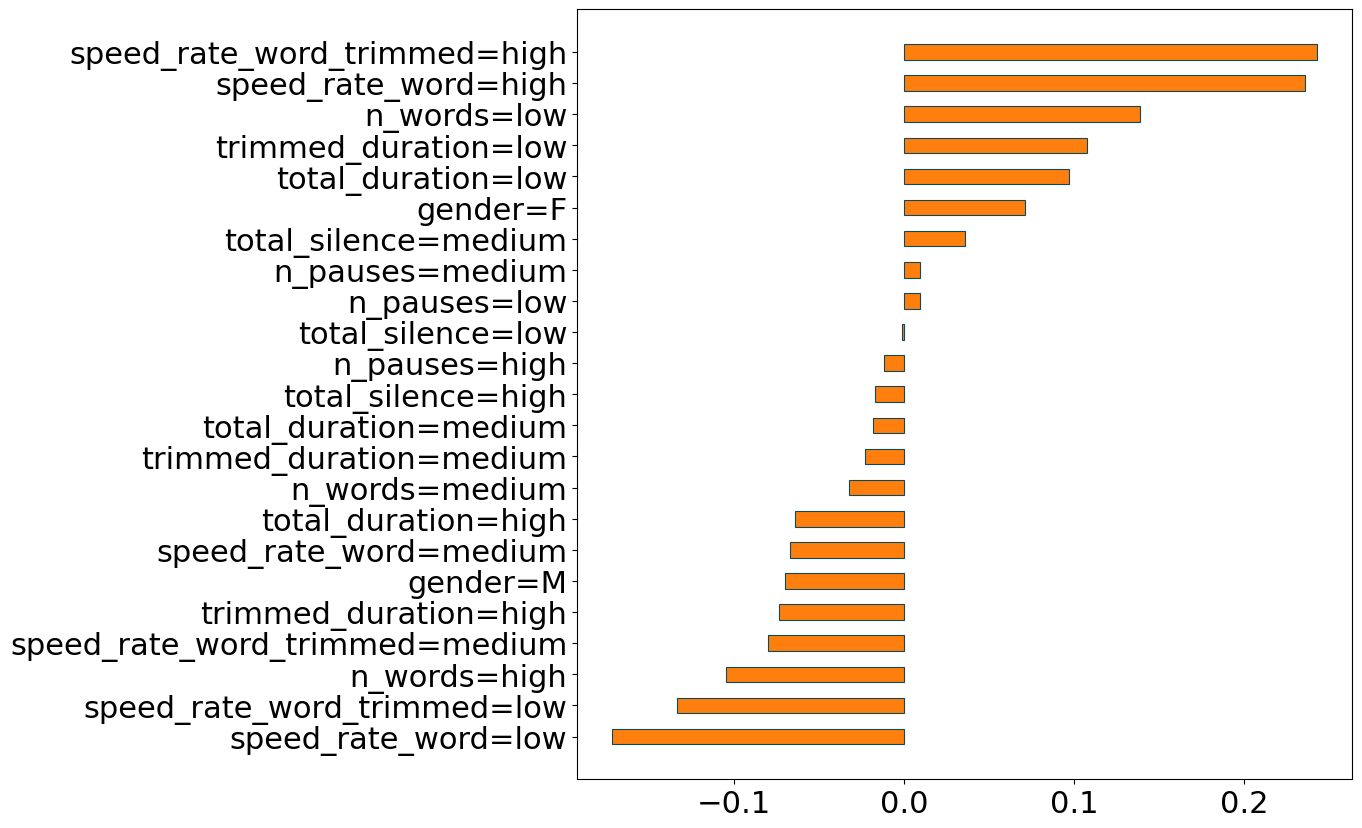

In [40]:
# Individual and Global Divergence
print("---------- Individual Divergence ----------")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

print("---------- Global Divergence ----------")
global_item_divergence_hubb = fp_divergence_i.computeGlobalShapleyValue()

topK_global_hubb = {k:v*100 for k,v in global_item_divergence_hubb.items() 
                    if k in sorted(global_item_divergence_hubb, 
                    key=lambda x: abs(global_item_divergence_hubb[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_hubb, 
                sizeFig=(10,10), labelsize=22, titlesize=22)

# Divergence HuBERT-Large

In [41]:
## Compute the divergence for HuBERT large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]

,itemsets,support,WER,d_WER,t_value
2410,"gender=F, n_pauses=low, speakRate_trim=high, trim_dur=low",0.03,10.800,7.300,2.71
2407,"gender=F, n_pauses=low, speakRate_trim=high, tot_dur=low",0.03,10.782,7.282,2.69
928,"n_pauses=low, speakRate=high, speakRate_trim=high, tot_dur=low, trim_dur=low",0.06,10.383,6.883,3.76


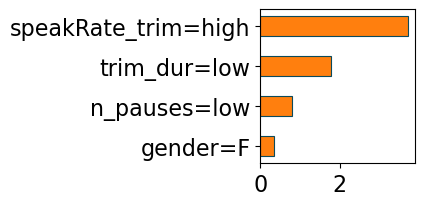

In [42]:
from copy import deepcopy

## Retrieve Most Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = ((pr["WER"] - HUBERT_LARGE_WER)).round(3)
pr_l = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_i.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

In [43]:
## Retrieve Top Performing Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.head(n).copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = (pr["WER"] - HUBERT_LARGE_WER).round(3)
pr_l = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l)

,itemsets,support,WER,d_WER,t_value
2073,"gender=M, n_pauses=low, n_words=medium, speakRate=low",0.04,1.811,-1.689,5.99
1424,"gender=M, n_words=medium, speakRate=low",0.05,1.856,-1.644,6.47
2295,"gender=M, speakRate=low, speakRate_trim=low, tot_silence=medium",0.03,1.961,-1.539,5.09


WER:  10.097
Δ_WER:  6.597


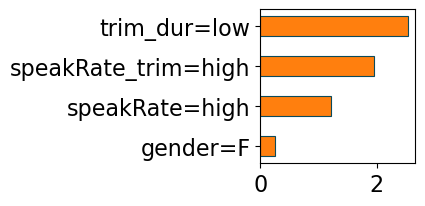

WER:  9.371
Δ_WER:  5.871


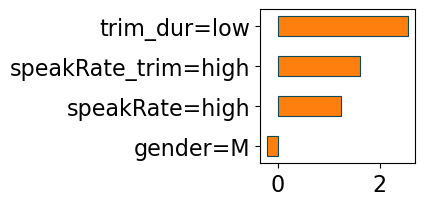

In [44]:
## Subgroup: {'gender=F', 'speakRate_trim=high', 'speakRate=high', 'trim_dur=low'}
negative_itemset = frozenset({'gender=F', 'speed_rate_word_trimmed=high', 'speed_rate_word=high', 'trimmed_duration=low'})
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)
pr_ni = FPdiv.copy()
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("WER: ", round(wer,3))
print("Δ_WER: ", round(wer - HUBERT_LARGE_WER,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

## Subgroup: {'gender=M', 'speakRate_trim=high', 'speakRate=high', 'trim_dur=low'}
negative_itemset = frozenset({'gender=M', 'speed_rate_word_trimmed=high', 'speed_rate_word=high', 'trimmed_duration=low'})
wer = pr_ni[pr_ni['itemsets'] == negative_itemset].WER.values[0]*100
print("WER: ", wer)
print("Δ_WER: ", round(wer - HUBERT_LARGE_WER,3))

itemset_shap = fp_divergence_i.computeShapleyValue(negative_itemset)
itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                sizeFig=(2,2), labelsize=16, titlesize=16)

---------- Individual Divergence ----------


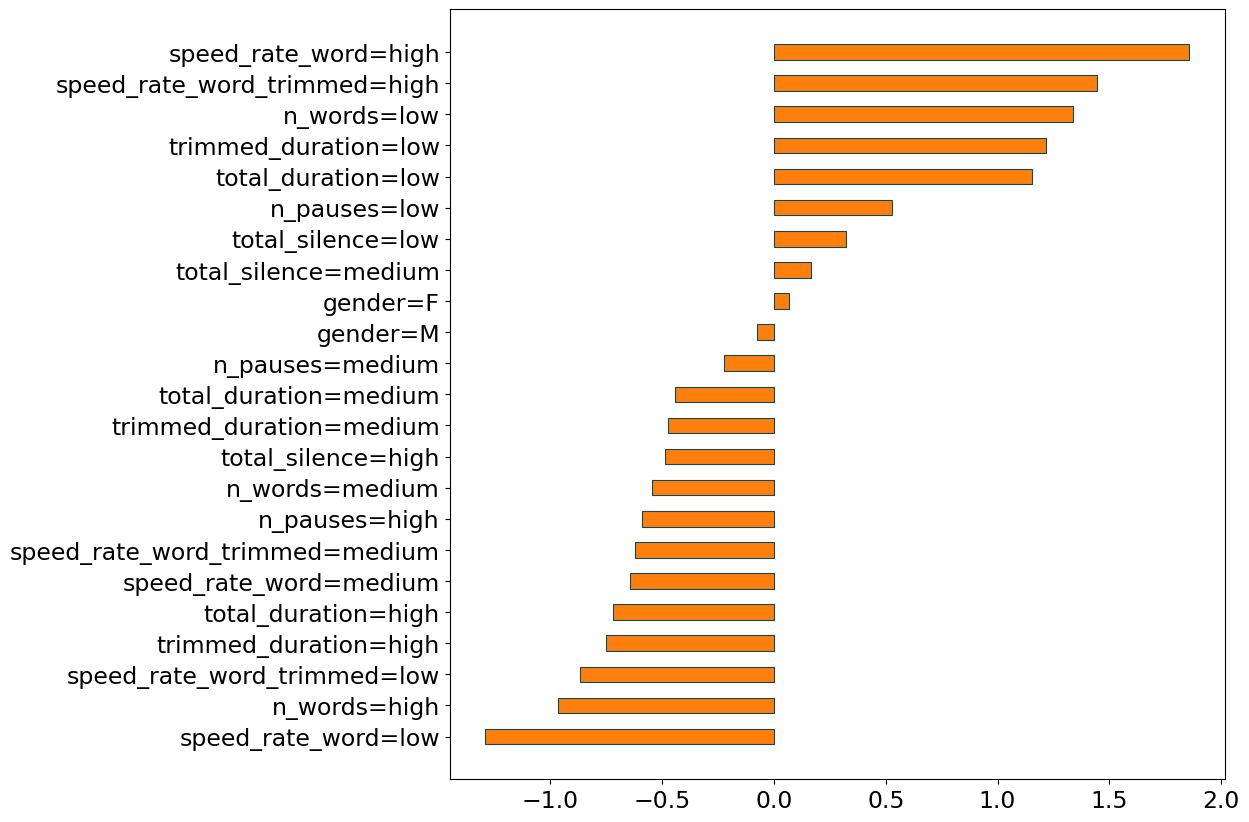

---------- Global Divergence ----------


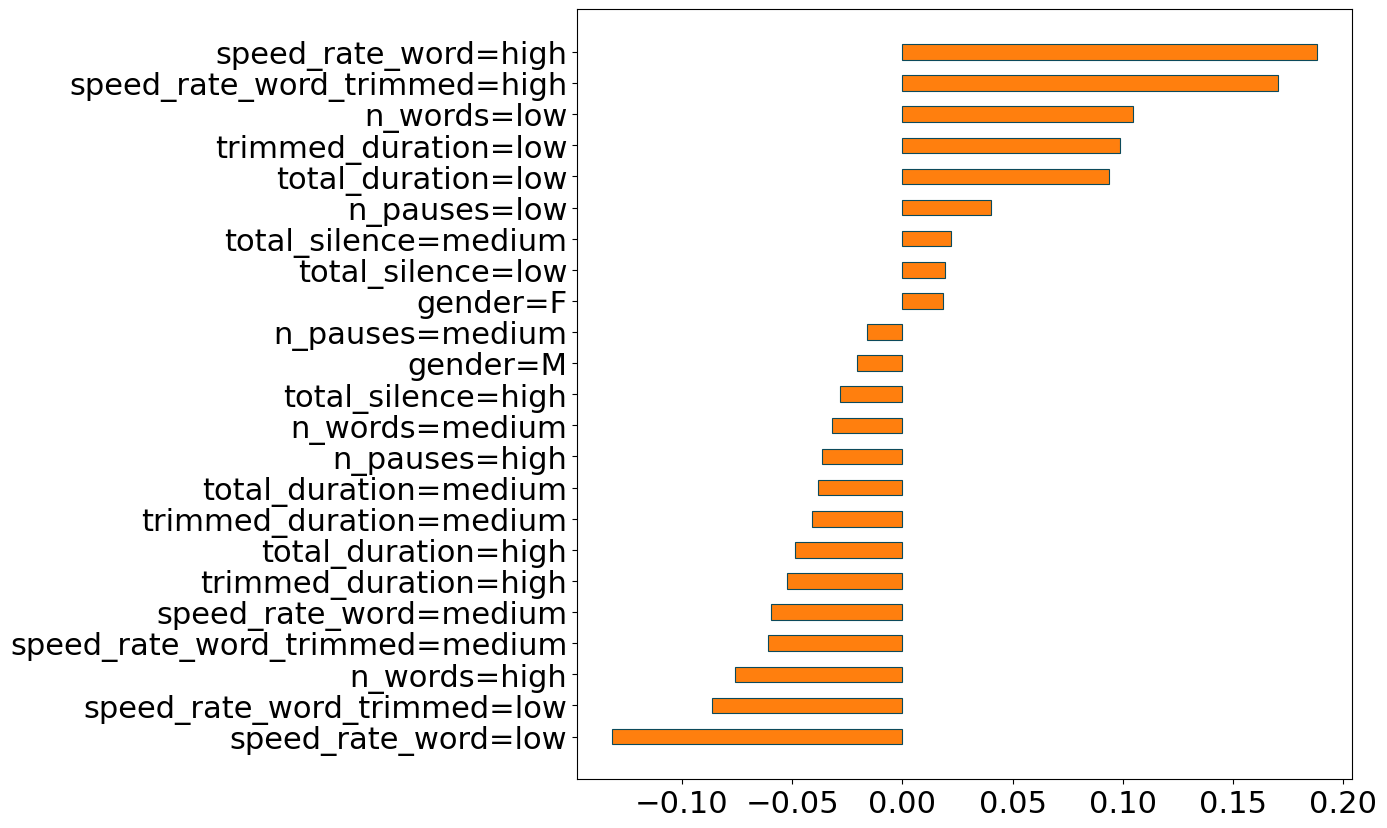

In [45]:
# Individual and Global Divergence
print("---------- Individual Divergence ----------")
individual_divergence = fp_divergence_i.getFItemsetsDivergence()[1]
individual_divergence = {k:v*100 for k,v in individual_divergence.items()}
plotShapleyValue(shapley_values=individual_divergence, 
                sizeFig=(10,10), labelsize=17, titlesize=17)

print("---------- Global Divergence ----------")
global_item_divergence_hubl = fp_divergence_i.computeGlobalShapleyValue()

topK_global_hubl = {k:v*100 for k,v in global_item_divergence_hubl.items() 
                    if k in sorted(global_item_divergence_hubl, 
                    key=lambda x: abs(global_item_divergence_hubl[x]))[::-1][:K]}

plotShapleyValue(shapley_values=topK_global_hubl, 
                sizeFig=(10,10),labelsize=22, titlesize=22)

# Divergence difference Wav2Vec2-Base vs Wav2Vec2-Large

In [46]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wlarge = FPdiv_w2l.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2b = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_w2b.set_index("itemsets")

## Merge the df
merged = wbase.join(wlarge, lsuffix='_base', rsuffix='_large')
merged = merged.rename(columns={'support_large': 'support'})

In [47]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["WER_large"] - merged["WER_base"]
merged["difference"] = merged["WER_large"] - merged["WER_base"]

In [48]:
## Create "Gain Base-Large W2V2" df and compute divergence
base_large_gain_df = merged[['support', 'WER_large', 'd_WER_large', 't_value_large', \
       'support_count_large', 'length_large'] \
       + [diff, "difference", "WER_base"]]
base_large_gain_df = base_large_gain_df.rename(columns={'length_large':'length'})
base_large_gain_df = base_large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(base_large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [49]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'WER_base', 'WER_large', 'support']

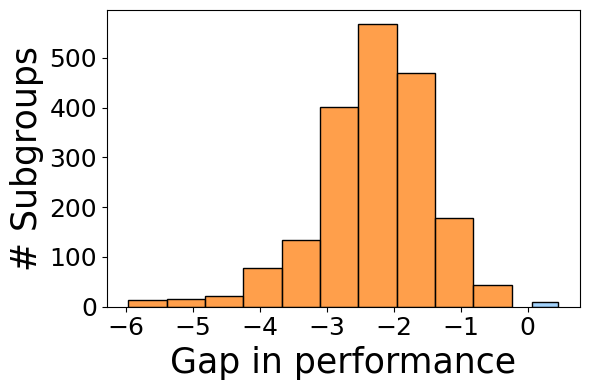

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_pos = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")
list_diff_neg = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
sns.histplot(list_diff_neg, bins=1, kde=False, ax=ax, color='#83C4FA', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=25)
ax.set_ylabel(r"# Subgroups", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/LibriSpeech/distribution_gain_w2v2_base_large.pdf")

## Stats

In [51]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are lower for Wav2Vec2-Large
# (The higher the WER the lower the performance)
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are greater for Wav2Vec2-Large
# (The lower the WER the greater the performance)
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
0.0
Greater
0.7457
Lower
99.2543


## Gain > 0

In [52]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs worse than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["WER_large"] = (pr["WER_large"]*100).round(2)
pr["WER_base"] = (pr["WER_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_base,WER_large,support
0,"gender=M, n_pauses=low, speakRate_trim=high, tot_dur=low, trim_dur=low",0.46,10.17,10.64,0.04
1,"gender=M, n_pauses=low, speakRate_trim=high, trim_dur=low",0.45,9.89,10.34,0.04


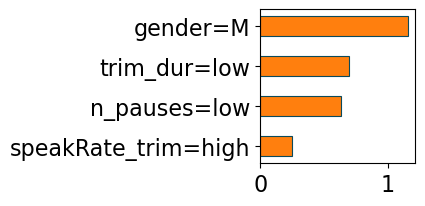

In [53]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[1].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [54]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs better than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["WER_large"] = (pr["WER_large"]*100).round(2)
pr["WER_base"] = (pr["WER_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_base,WER_large,support
0,"gender=F, n_pauses=low, speakRate_trim=high, trim_dur=low",-5.97,17.30,11.33,0.03
1,"speakRate_trim=high, tot_dur=low, tot_silence=medium, trim_dur=low",-5.94,13.52,7.58,0.03


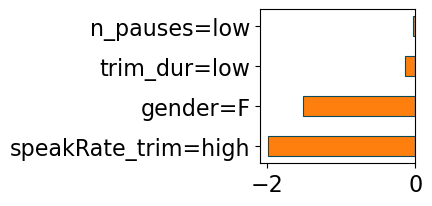

In [55]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain = 0 

In [56]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support_large"] = pr["support"].round(2)
pr["WER_large"] = (pr["WER_large"]*100).round(2)
pr["WER_base"] = (pr["WER_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("WER_large").sort_values("WER_large")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_base,WER_large,support,support_large


In [57]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Global Shapley value

In [58]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and Wav2Vec2-Large
global_item_divergence_w2b_w2l = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_w2l = {k:v for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(global_item_divergence_w2b_w2l, 
                        key=lambda x: abs(global_item_divergence_w2b_w2l[x]))[::-1][:K]}

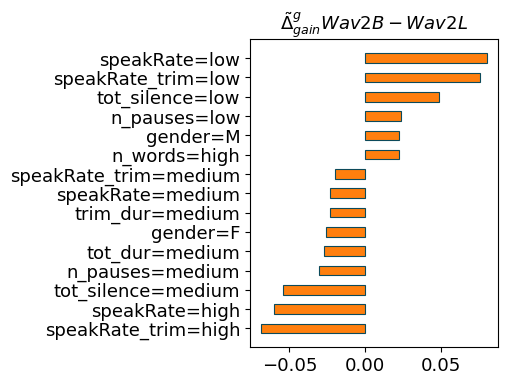

In [59]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_w2b_w2l_abbr = abbreviateDict(topK_global_w2b_w2l, abbreviations)
topK_global_w2b_w2l_abbr = {k:v*100 for k,v in topK_global_w2b_w2l_abbr.items()}
name_fig = "plot_results/LibriSpeech/global_shapley_gain_w2b_w2l.pdf"
plotShapleyValue(shapley_values=topK_global_w2b_w2l_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title=r"$\tilde{\Delta}^g_{gain} Wav2B - Wav2L$",
                nameFig=name_fig, saveFig=False)

# Divergence difference HuBERT-Base vs HuBERT-Large

In [60]:
## Compute the divergence for HuBERT-Large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hlarge = FPdiv_hl.set_index("itemsets")

## Compute the divergence for HuBERT-Base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hbase = FPdiv_hb.set_index("itemsets")

## Merge the df
merged = hbase.join(hlarge, lsuffix='_base', rsuffix='_large')
merged = merged.rename(columns={'support_large': 'support'})

In [61]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["WER_large"] - merged["WER_base"]
merged["difference"] = merged["WER_large"] - merged["WER_base"]

In [62]:
## Create "Gain Base-Large Hub" df and compute divergence
base_large_gain_df = merged[['support', 'WER_large', 'd_WER_large', 't_value_large', \
       'support_count_large', 'length_large'] \
       + [diff, "difference", "WER_base"]]
base_large_gain_df = base_large_gain_df.rename(columns={'length_large':'length'})
base_large_gain_df = base_large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(base_large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [63]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'WER_base', 'WER_large', 'support']

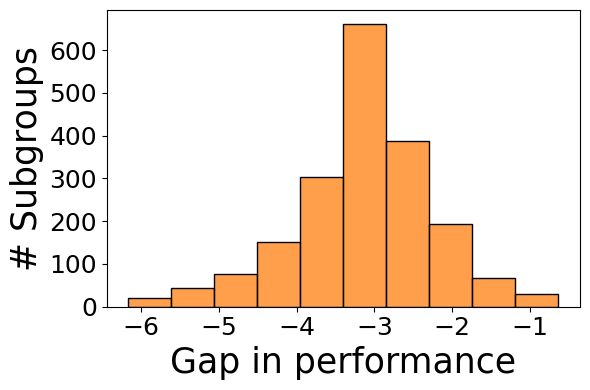

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_pos = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")
list_diff_neg = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
sns.histplot(list_diff_neg, bins=1, kde=False, ax=ax, color='#83C4FA', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=25)
ax.set_ylabel(r"# Subgroups", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/LibriSpeech/distribution_gain_hub_base_large.pdf")

## Stats

In [65]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are lower for HuBERT-Large
# (The higher the WER the lower the performance)
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are greater for HuBERT-Large
# (The higher the WER the lower the performance)
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
0.0
Greater
0.0
Lower
100.0


## Gain > 0

In [66]:
## Retrieve the data cohorts for which HuBERT-Large performs worse than HuBERT-Base
pr = compare_performance[cols].head(2).reset_index()
pr = pr[pr['d_difference'] > 0.0]
pr["support"] = pr["support"].round(2)
pr["WER_large"] = (pr["WER_large"]*100).round(2)
pr["WER_base"] = (pr["WER_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_base,WER_large,support


In [67]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [68]:
## Retrieve the data cohorts for which HuBERT-Large performs better than HuBERT-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["WER_large"] = (pr["WER_large"]*100).round(2)
pr["WER_base"] = (pr["WER_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_base,WER_large,support
0,"gender=F, speakRate=high, speakRate_trim=high, trim_dur=low",-6.16,16.26,10.10,0.04
1,"gender=F, speakRate=high, speakRate_trim=high, tot_silence=medium",-6.13,12.75,6.62,0.04


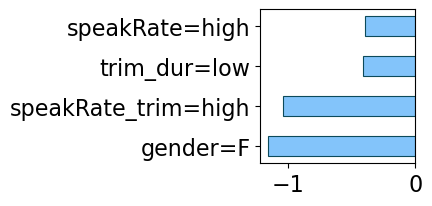

In [69]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [70]:
## Retrieve the data cohorts for which HuBERT-Large performs equal to HuBERT-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support_large"] = pr["support"].round(2)
pr["WER_large"] = (pr["WER_large"]*100).round(2)
pr["WER_base"] = (pr["WER_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("WER_large").sort_values("WER_large")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_base,WER_large,support,support_large


In [71]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Global Shapley value

In [72]:
## Compute the top-K global shapley values related to the gain in performance between HuBERT-Base and HuBERT-Large
global_item_divergence_hb_hl = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_hb_hl = {k:v for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(global_item_divergence_hb_hl, 
                        key=lambda x: abs(global_item_divergence_hb_hl[x]))[::-1][:K]}

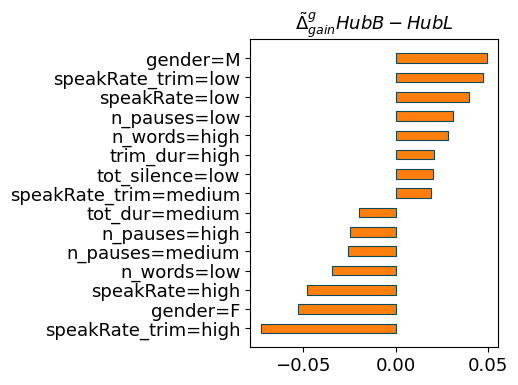

In [73]:
## Plot and Save the image
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_hb_hl_abbr = abbreviateDict(topK_global_hb_hl, abbreviations)
topK_global_hb_hl_abbr = {k:v*100 for k,v in topK_global_hb_hl_abbr.items()}
name_fig = "plot_results/LibriSpeech/global_shapley_gain_hb_hl.pdf"
plotShapleyValue(shapley_values=topK_global_hb_hl_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title=r"$\tilde{\Delta}^g_{gain} HubB - HubL$",
                nameFig=name_fig, saveFig=False)

# Divergence difference Wav2Vec2-Base vs HuBERT-Base

In [74]:
## Compute the divergence for HuBERT-base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hbase = FPdiv_hb.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2b = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_w2b.set_index("itemsets")

## Merge the df
merged = wbase.join(hbase, lsuffix='_w2base', rsuffix='_hbase')
merged = merged.rename(columns={'support_hbase': 'support'})

In [75]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["WER_hbase"] - merged["WER_w2base"]
merged["difference"] = merged["WER_hbase"] - merged["WER_w2base"]

In [76]:
## Create "Gain W2V2Base-HubBase" df and compute divergence
w2base_hbase_gain_df = merged[['support', 'WER_hbase', 'd_WER_hbase', 't_value_hbase', \
       'support_count_hbase', 'length_hbase'] \
       + [diff, "difference", "WER_w2base"]]
w2base_hbase_gain_df = w2base_hbase_gain_df.rename(columns={'length_hbase':'length'})
w2base_hbase_gain_df = w2base_hbase_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(w2base_hbase_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [77]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'WER_w2base', 'WER_hbase', 'support']

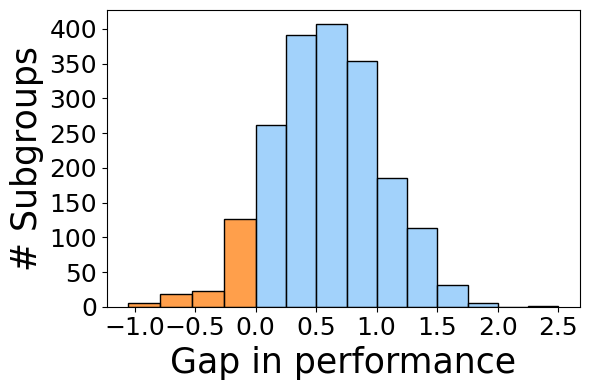

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_pos = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_pos, bins=4, kde=False, ax=ax, color='C01', palette="colorblind")
list_diff_neg = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
sns.histplot(list_diff_neg, bins=10, kde=False, ax=ax, color='#83C4FA', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=25)
ax.set_ylabel(r"# Subgroups", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/LibriSpeech/distribution_gain_w2v2_hub_base.pdf")

## Stats

In [79]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for HuBERT-Base
# (The higher the WER the lower the performance)
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are greater for HuBERT-Base
# (The higher the WER the lower the performance)
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
0.0
Greater
89.768
Lower
10.232


## Gain > 0

In [80]:
## Retrieve the data cohorts for which HuBERT-Base performs worse than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["WER_hbase"] = (pr["WER_hbase"]*100).round(2)
pr["WER_w2base"] = (pr["WER_w2base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_w2base,WER_hbase,support
0,"gender=M, n_pauses=low, n_words=low, tot_silence=medium",2.5,7.60,10.11,0.03
1,"gender=M, speakRate=low, speakRate_trim=low, trim_dur=low",1.8,5.26,7.06,0.03


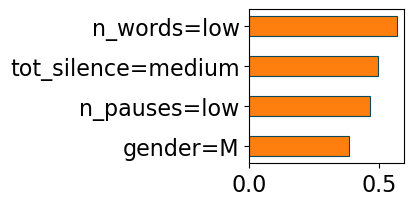

In [81]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [82]:
## Retrieve the data cohorts for which HuBERT-Base performs better than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["WER_hbase"] = (pr["WER_hbase"]*100).round(2)
pr["WER_w2base"] = (pr["WER_w2base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_w2base,WER_hbase,support
0,"n_pauses=medium, speakRate=medium, tot_dur=medium, tot_silence=medium",-1.05,7.44,6.39,0.04
1,"gender=F, n_pauses=low, speakRate_trim=high, tot_dur=low",-0.96,17.03,16.07,0.03


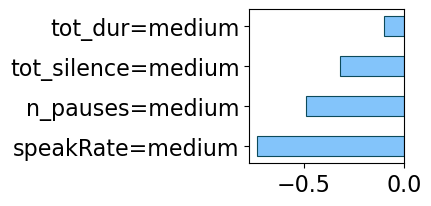

In [83]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [84]:
## Retrieve the data cohorts for which HuBERT-Base performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["WER_hbase"] = (pr["WER_hbase"]*100).round(2)
pr["WER_w2base"] = (pr["WER_w2base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("WER_hbase").sort_values("WER_hbase")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_w2base,WER_hbase,support
1750,"n_pauses=low, n_words=medium, tot_silence=medium, trim_dur=medium",0.0,5.37,5.37,0.04
1756,"gender=M, n_pauses=high, speakRate_trim=medium, tot_dur=high, tot_silence=high",-0.0,5.38,5.37,0.04


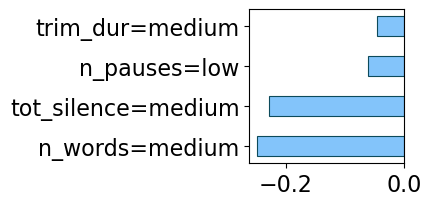

In [85]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Global Shapley value

In [86]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and HuBERT-Base
global_item_divergence_w2b_hb = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_hb = {k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(global_item_divergence_w2b_hb, 
                        key=lambda x: abs(global_item_divergence_w2b_hb[x]))[::-1][:K]}

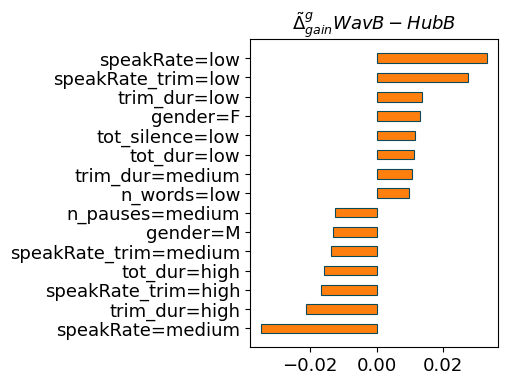

In [87]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_w2b_hb_abbr = abbreviateDict(topK_global_w2b_hb, abbreviations)
topK_global_w2b_hb_abbr = {k:v*100 for k,v in topK_global_w2b_hb_abbr.items()}
name_fig = "plot_results/LibriSpeech/global_shapley_gain_w2b_hb.pdf"
plotShapleyValue(shapley_values=topK_global_w2b_hb_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title=r"$\tilde{\Delta}^g_{gain} WavB - HubB$",
                nameFig=name_fig, saveFig=False)

# Divergence difference Wav2Vec2-Large vs HuBERT-Large

In [88]:
## Compute the divergence for HuBERT-Large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hl = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hlarge = FPdiv_hl.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wlarge = FPdiv_w2l.set_index("itemsets")

## Merge the df
merged = wlarge.join(hlarge, lsuffix='_w2large', rsuffix='_hlarge')
merged = merged.rename(columns={'support_hlarge': 'support'})

In [89]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["WER_hlarge"] - merged["WER_w2large"]
merged["difference"] = merged["WER_hlarge"] - merged["WER_w2large"]

In [90]:
## Create "Gain W2V2Large-HubLarge" df and compute divergence
w2large_hlarge_gain_df = merged[['support', 'WER_hlarge', 'd_WER_hlarge', 't_value_hlarge', \
       'support_count_hlarge', 'length_hlarge'] \
       + [diff, "difference", "WER_w2large"]]
w2large_hlarge_gain_df = w2large_hlarge_gain_df.rename(columns={'length_hlarge':'length'})
w2large_hlarge_gain_df = w2large_hlarge_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(w2large_hlarge_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [91]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'WER_w2large', 'WER_hlarge', 'support']

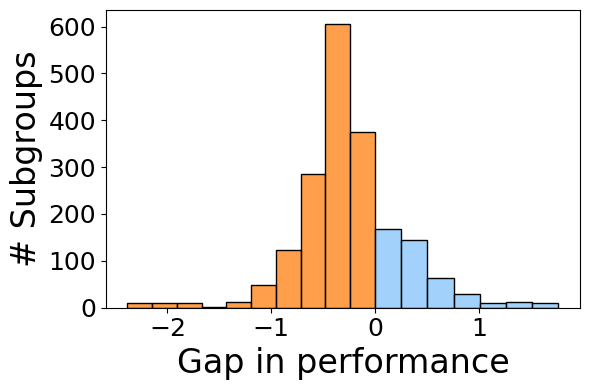

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ## plot the distribution of the positive gain in performance
# list_diff_pos = list(compare_performance[compare_performance['d_difference'] > 0.0].d_difference)
# list_diff_pos = [i * 100 for i in list_diff_pos]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_pos, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


# ## plot the distribution of the negative gain in performance
# list_diff_neg = list(compare_performance[compare_performance['d_difference'] < 0.0].d_difference)
# list_diff_neg = [i * 100 for i in list_diff_neg]
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.distplot(list_diff_neg, bins=20, kde=False, ax=ax)
# ax.set_xlabel("Gain in performance", fontsize=18)
# ax.set_ylabel("Number of Subgroups", fontsize=18)
# ax.set_title("Distribution of the gain in performance", fontsize=19)
# plt.tight_layout()
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)


## plot the distribution of the gain in performance
list_diff_pos = list(compare_performance[compare_performance['d_difference'] <= 0.0].d_difference)
list_diff_pos = [i * 100 for i in list_diff_pos]
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(list_diff_pos, bins=10, kde=False, ax=ax, color='C01', palette="colorblind")
list_diff_neg = list(compare_performance[compare_performance['d_difference'] >= 0.0].d_difference)
list_diff_neg = [i * 100 for i in list_diff_neg]
sns.histplot(list_diff_neg, bins=7, kde=False, ax=ax, color='#83C4FA', palette="colorblind")

ax.set_xlabel("Gap in performance", fontsize=24)
ax.set_ylabel(r"# Subgroups", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("plot_results/LibriSpeech/distribution_gain_w2v2_hub_large.pdf")

## Stats

In [93]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are lower for HuBERT-Large
# (The higher the WER the lower the performance)
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are greater for HuBERT-Large
# (The higher the WER the lower the performance)
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
0.2071
Greater
20.5882
Lower
79.2046


## Gain > 0

In [94]:
## Retrieve the data cohorts for which HuBERT-Large performs worse than Wav2Vec2-Large
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["WER_hlarge"] = (pr["WER_hlarge"]*100).round(2)
pr["WER_w2large"] = (pr["WER_w2large"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_w2large,WER_hlarge,support
0,"speakRate_trim=high, tot_dur=low, tot_silence=medium, trim_dur=low",1.77,7.58,9.35,0.03
1,"n_pauses=low, n_words=low, speakRate_trim=high, tot_silence=medium",1.74,7.91,9.64,0.03


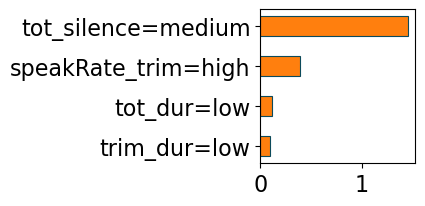

In [95]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Gain < 0 

In [96]:
## Retrieve the data cohorts for which HuBERT-Large performs better than Wav2Vec2-Large
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["WER_hlarge"] = (pr["WER_hlarge"]*100).round(2)
pr["WER_w2large"] = (pr["WER_w2large"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_w2large,WER_hlarge,support
0,"speakRate=high, speakRate_trim=high, tot_dur=low, tot_silence=low, trim_dur=low",-2.38,12.53,10.14,0.05
1,"speakRate=high, speakRate_trim=high, tot_dur=low, tot_silence=low",-2.35,12.56,10.21,0.05


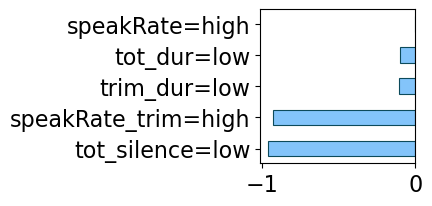

In [97]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16, negative=True)

## Gain = 0 

In [98]:
## Retrieve the data cohorts for which HuBERT-Large performs equal to Wav2Vec2-Large
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["WER_hlarge"] = (pr["WER_hlarge"]*100).round(2)
pr["WER_w2large"] = (pr["WER_w2large"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]
pr = pr.sort_values("WER_hlarge").sort_values("WER_hlarge")

## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,WER_w2large,WER_hlarge,support
437,"gender=M, speakRate=medium, speakRate_trim=medium, trim_dur=medium",-0.0,2.80,2.80,0.03
433,"n_pauses=low, tot_silence=low, trim_dur=medium",0.0,2.84,2.84,0.08


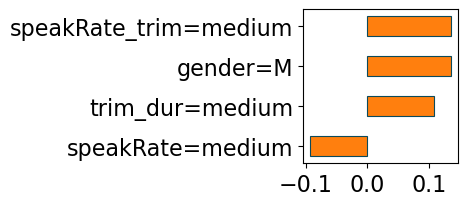

In [99]:
## Compute Shapley Values for a given itemset
if len(pr) > 0:
    itemset_1 = pr.iloc[0].itemsets
    itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
    itemset_shap = {k:v*100 for k,v in itemset_shap.items()}
    plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                    sizeFig=(2,2), labelsize=16, titlesize=16)

## Global Shapley value

In [100]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Large and HuBERT-Large
global_item_divergence_w2l_hl = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2l_hl = {k:v for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(global_item_divergence_w2l_hl, 
                        key=lambda x: abs(global_item_divergence_w2l_hl[x]))[::-1][:K]}

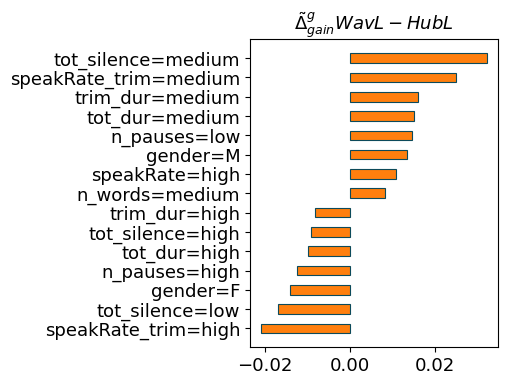

In [101]:
## Plot and Save the image 
sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

topK_global_w2l_hl_abbr = abbreviateDict(topK_global_w2l_hl, abbreviations)
topK_global_w2l_hl_abbr = {k:v*100 for k,v in topK_global_w2l_hl_abbr.items()}
name_fig = "plot_results/LibriSpeech/global_shapley_gain_w2l_hl.pdf"
plotShapleyValue(shapley_values=topK_global_w2l_hl_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title=r"$\tilde{\Delta}^g_{gain} WavL - HubL$",
                nameFig=name_fig, saveFig=False)

# Global Shapley value comparison

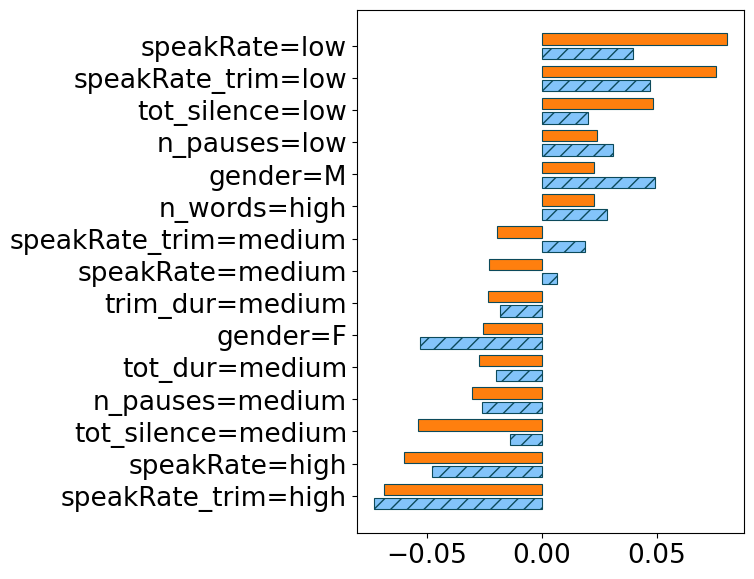

In [102]:
## Take the K Global Shapley Values for HubL-HubB starting from the top-K of WavL-WavB
topK_global_hb_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_w2l_hb_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_w2l_hb_hl_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_w2l_abbr, 
            shapley_values_2=topK_global_hb_hl_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

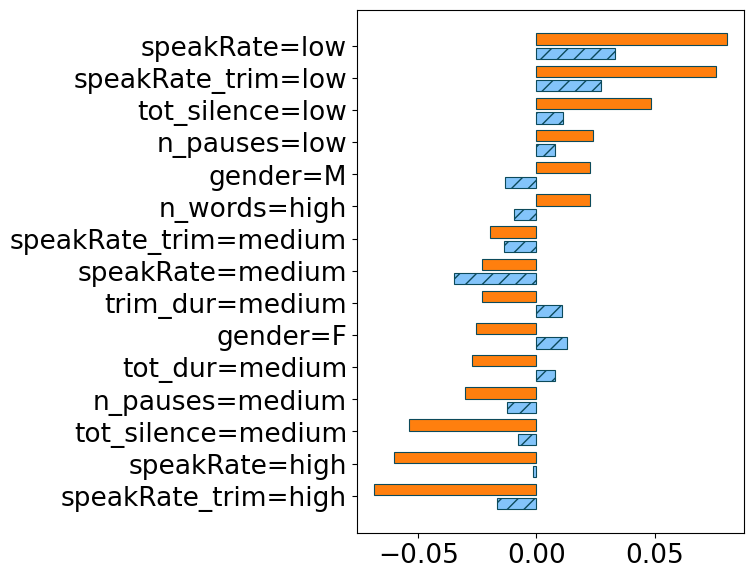

In [103]:
## Take the K Global Shapley Values for HubB-WavB starting from the top-K of WavL-WavB
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_w2l_w2b_hb_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_w2l_w2b_hb_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_w2l_abbr, 
            shapley_values_2=topK_global_w2b_hb_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

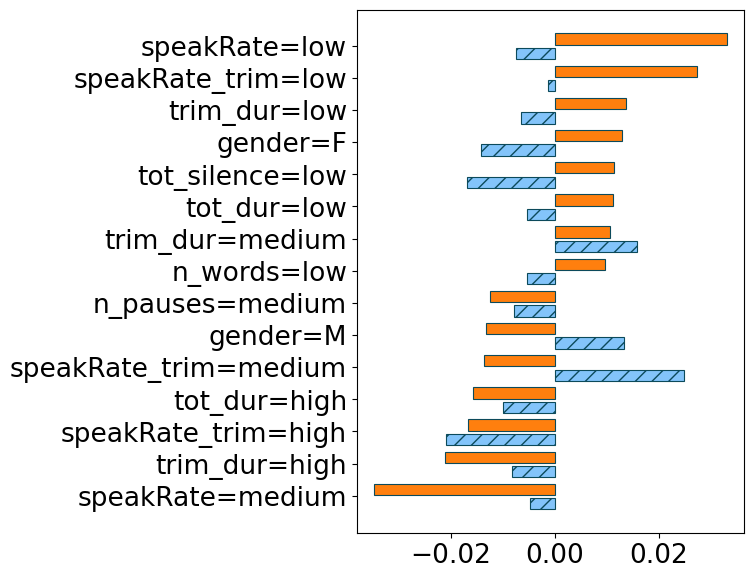

In [104]:
## Take the K Global Shapley Values for WavL-HubL starting from the top-K of WavB-HubB
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)

name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
legend = False
if legend:
    name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_hb_w2l_hl_{K}_legend.pdf"

## Plot and Save Image for Global Shapley Value Comparison
plotMultipleSV(shapley_values_1=topK_global_w2b_hb_abbr, 
            shapley_values_2=topK_global_w2l_hl_1_abbr,
            labelsize=labelsize, sizeFig=sizeFig, height=height, 
            legend=legend, nameFig=name_fig, saveFig=False)

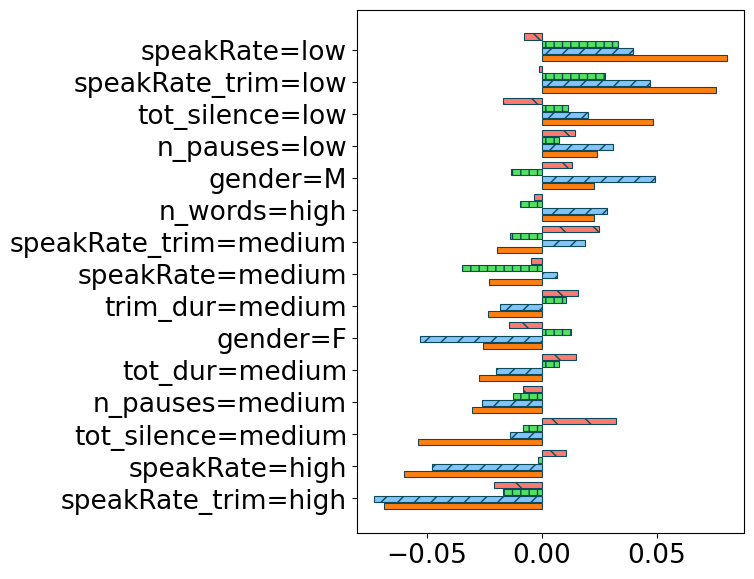

In [105]:
## Take the K Global Shapley Values for HubB-HubL starting from the top-K of WavB-WavL
topK_global_hb_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

## Take the K Global Shapley Values for Wav2B-HubB starting from the top-K of WavB-WavL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

## Take the K Global Shapley Values for Wav2L-HubL starting from the top-K of WavB-WavL
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_w2l_hb_hl_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_w2l_hb_hl_w2b_hb_w2l_hl_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_abbr, 
                shapley_values_2=topK_global_hb_hl_1_abbr,
                shapley_values_3=topK_global_w2b_hb_1_abbr,
                shapley_values_4=topK_global_w2l_hl_1_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)

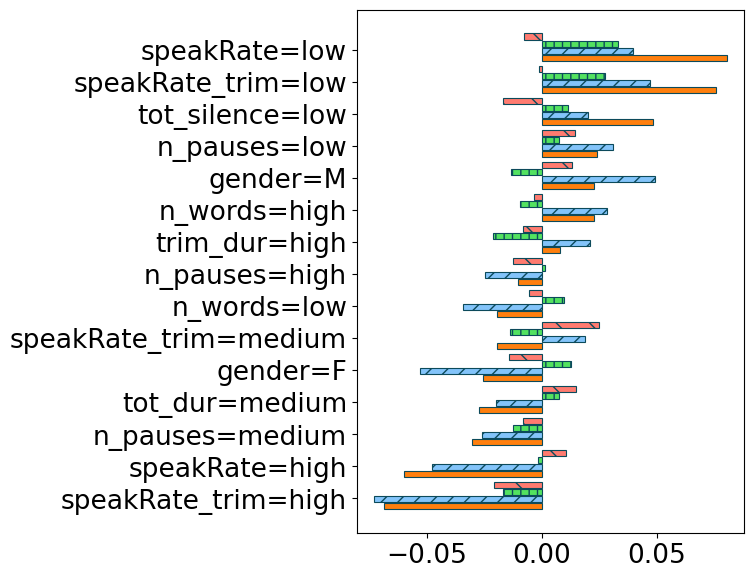

In [106]:
## Take the K Global Shapley Values for Wav2B-Wav2L starting from the top-K of HubB-HubL
topK_global_w2b_w2l_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(topK_global_hb_hl)}, abbreviations)

## Take the K Global Shapley Values for Wav2B-HubB starting from the top-K of HubB-HubL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_hb_hl)}, abbreviations)

## Take the K Global Shapley Values for Wav2L-HubL starting from the top-K of HubB-HubL
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_hb_hl)}, abbreviations)

name_fig = f"plot_results/LibriSpeech/global_shapley_gain_hb_hl_w2b_w2l_w2b_hb_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/LibriSpeech/global_shapley_gain_hb_hl_w2b_w2l_w2b_hb_w2l_hl_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_1_abbr, 
                shapley_values_2=topK_global_hb_hl_abbr,
                shapley_values_3=topK_global_w2b_hb_1_abbr,
                shapley_values_4=topK_global_w2l_hl_1_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)

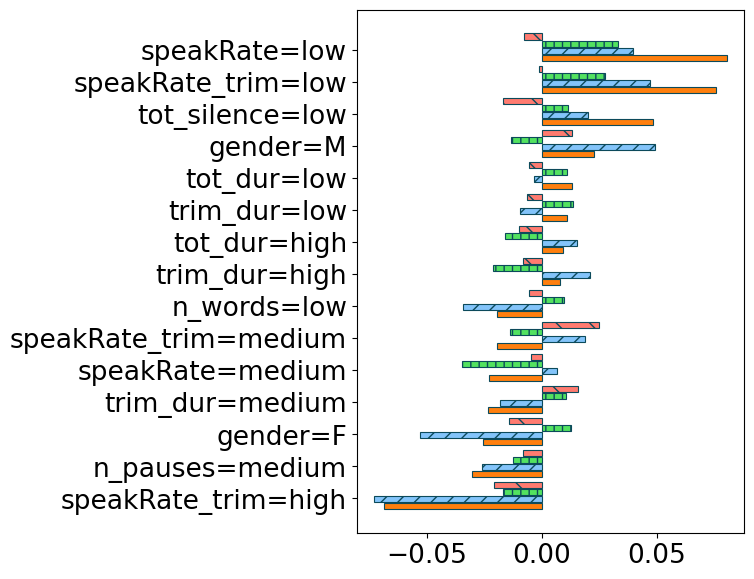

In [107]:
## Take the K Global Shapley Values for Wav2B-Wav2L starting from the top-K of Wav2B-HubB
topK_global_w2b_w2l_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)

## Take the K Global Shapley Values for HubB-HubL starting from the top-K of Wav2B-HubB
topK_global_hb_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)

## Take the K Global Shapley Values for Wav2L-HubL starting from the top-K of Wav2B-HubB
topK_global_w2l_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2l_hl.items() \
                        if k in sorted(topK_global_w2b_hb)}, abbreviations)

name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_hb_w2b_w2l_hb_hl_w2l_hl_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2b_hb_w2b_w2l_hb_hl_w2l_hl_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_1_abbr, 
                shapley_values_2=topK_global_hb_hl_1_abbr,
                shapley_values_3=topK_global_w2b_hb_abbr,
                shapley_values_4=topK_global_w2l_hl_1_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)

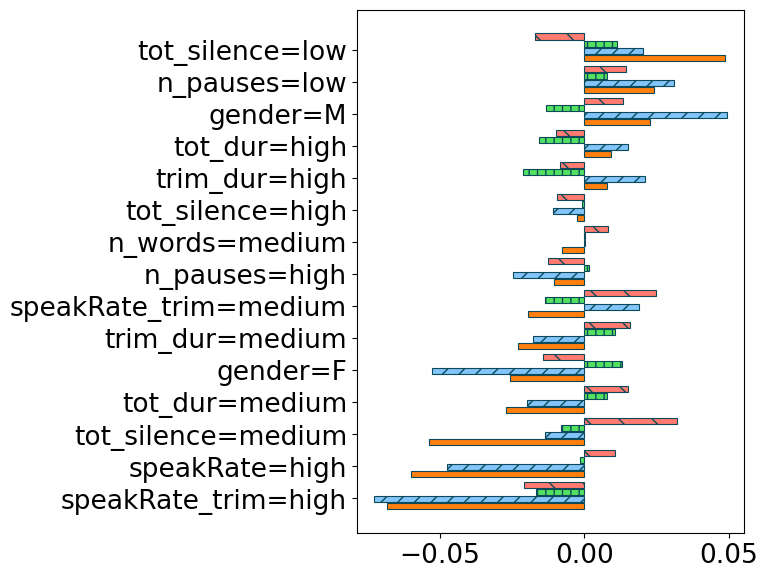

In [108]:
## Take the K Global Shapley Values for Wav2B-Wav2L starting from the top-K of Wav2L-HubL
topK_global_w2b_w2l_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)

## Take the K Global Shapley Values for HubB-HubL starting from the top-K of Wav2L-HubL
topK_global_hb_hl_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_hb_hl.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)

## Take the K Global Shapley Values for Wav2B-HubB starting from the top-K of Wav2L-HubL
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v*100 for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2l_hl)}, abbreviations)

name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2l_hl_w2b_w2l_hb_hl_w2b_hb_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.2
legend = False
if legend:
    name_fig = f"plot_results/LibriSpeech/global_shapley_gain_w2l_hl_w2b_w2l_hb_hl_w2b_hb_{K}_legend.pdf"
    
plotMultipleSV_4(shapley_values_1=topK_global_w2b_w2l_1_abbr, 
                shapley_values_2=topK_global_hb_hl_1_abbr,
                shapley_values_3=topK_global_w2b_hb_1_abbr,
                shapley_values_4=topK_global_w2l_hl_abbr,
                labelsize=labelsize, sizeFig=sizeFig, height=height, 
                legend=legend, nameFig=name_fig, saveFig=False)